<a href="https://www.kaggle.com/code/lalit7881/heart-disease-prediction-roc-auc-0-9563?scriptVersionId=295410503" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, TargetEncoder, PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, RobustScaler
from scipy import stats
#Imports for Stacking Models
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s6e2/sample_submission.csv
/kaggle/input/playground-series-s6e2/train.csv
/kaggle/input/playground-series-s6e2/test.csv


## Title
Heart Disease Prediction

### Description :
This project focuses on predicting the likelihood of heart disease in individuals using machine learning techniques. By analyzing clinical and lifestyle features such as age, gender, blood pressure, cholesterol levels, physical activity, and other relevant health indicators, the model identifies patterns that indicate potential heart disease risk. The workflow includes data preprocessing, feature selection, model training, and evaluation using metrics like accuracy, precision, recall, and F1-score. The ultimate goal is to provide an effective predictive tool that can assist healthcare professionals in early diagnosis, risk assessment, and preventive care planning for patients.

## Load dataset

In [2]:
# Load data
train = pd.read_csv(r"/kaggle/input/playground-series-s6e2/train.csv", index_col='id')
test = pd.read_csv(r"/kaggle/input/playground-series-s6e2/test.csv")
sample_submission = pd.read_csv(r"/kaggle/input/playground-series-s6e2/sample_submission.csv", index_col='id')

In [3]:
# Basic info
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Sample submission shape:", sample_submission.shape)

Train shape: (630000, 14)
Test shape: (270000, 14)
Sample submission shape: (270000, 1)


In [4]:
# Display first 5 rows
display(train.head())

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
id,,,,,,,,,,,,,,
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [5]:
# Display data types and missing values
print("\nData Info:")
train.info()



Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      630000 non-null  int64  
 1   Sex                      630000 non-null  int64  
 2   Chest pain type          630000 non-null  int64  
 3   BP                       630000 non-null  int64  
 4   Cholesterol              630000 non-null  int64  
 5   FBS over 120             630000 non-null  int64  
 6   EKG results              630000 non-null  int64  
 7   Max HR                   630000 non-null  int64  
 8   Exercise angina          630000 non-null  int64  
 9   ST depression            630000 non-null  float64
 10  Slope of ST              630000 non-null  int64  
 11  Number of vessels fluro  630000 non-null  int64  
 12  Thallium                 630000 non-null  int64  
 13  Heart Disease            630000 non-null  object 
dt

In [6]:
print("\nMissing Values per Column:")
print(train.isnull().sum())


Missing Values per Column:
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64


In [7]:
# Statistical summary
print("\nStatistical Summary:")
display(train.describe())


Statistical Summary:


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,54.136706,0.714735,3.312752,130.497433,245.011814,0.079987,0.981660,152.816763,0.273725,0.716028,1.455871,0.451040,4.618873
std,8.256301,0.451541,0.851615,14.975802,33.681581,0.271274,0.998783,19.112927,0.445870,0.948472,0.545192,0.798549,1.950007
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000
75%,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


In [8]:
# Check for duplicates
duplicates = train.duplicated().sum()
print(f"\nNumber of duplicate rows in train: {duplicates}")


Number of duplicate rows in train: 0


In [9]:
# Unique values per column
print("\nUnique values per column:")
for col in train.columns:
    print(f"{col}: {train[col].nunique()} unique values")



Unique values per column:
Age: 42 unique values
Sex: 2 unique values
Chest pain type: 4 unique values
BP: 66 unique values
Cholesterol: 150 unique values
FBS over 120: 2 unique values
EKG results: 3 unique values
Max HR: 93 unique values
Exercise angina: 2 unique values
ST depression: 66 unique values
Slope of ST: 3 unique values
Number of vessels fluro: 4 unique values
Thallium: 3 unique values
Heart Disease: 2 unique values


In [10]:
if 'target' in train.columns:
    print("\nTarget value counts:")
    print(train['target'].value_counts())
    sns.countplot(x='target', data=train)
    plt.title("Target Distribution")
    plt.show()

In [11]:
train.nunique()

Age                         42
Sex                          2
Chest pain type              4
BP                          66
Cholesterol                150
FBS over 120                 2
EKG results                  3
Max HR                      93
Exercise angina              2
ST depression               66
Slope of ST                  3
Number of vessels fluro      4
Thallium                     3
Heart Disease                2
dtype: int64

## Data visualizations

In [12]:
train_cols = train.columns
test_cols = test.columns

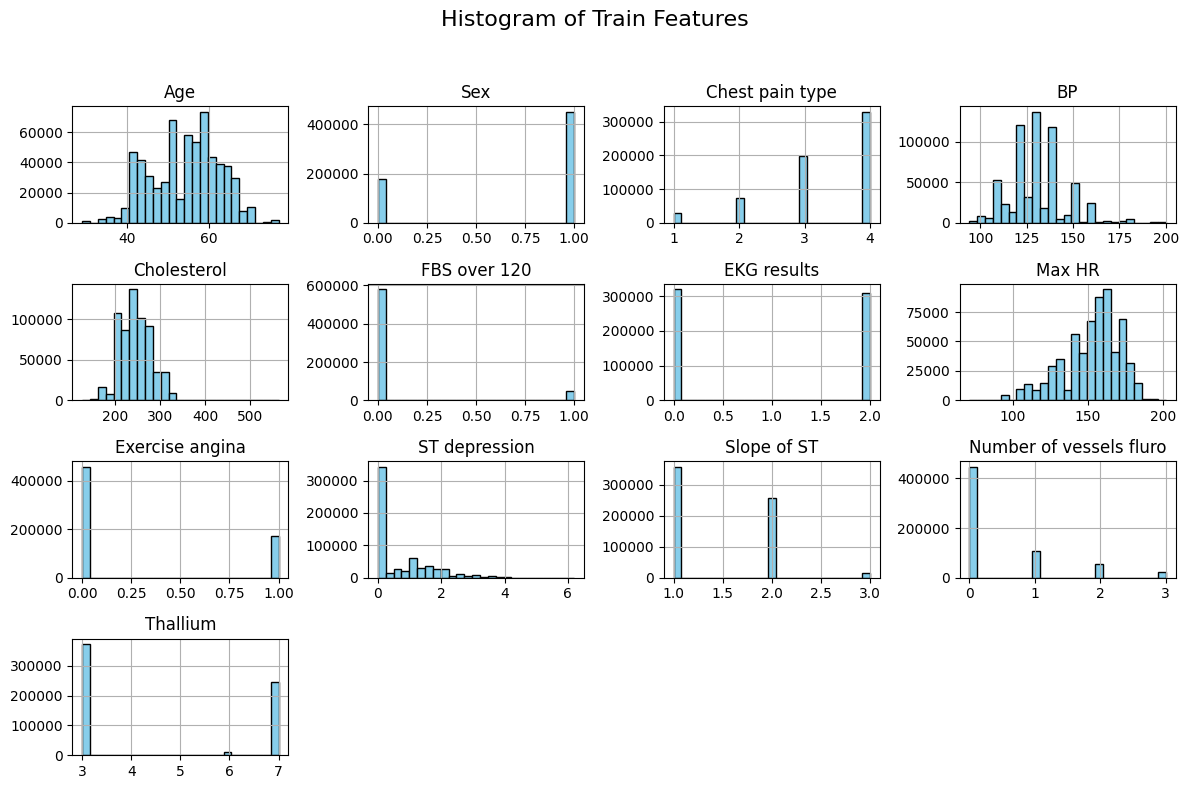

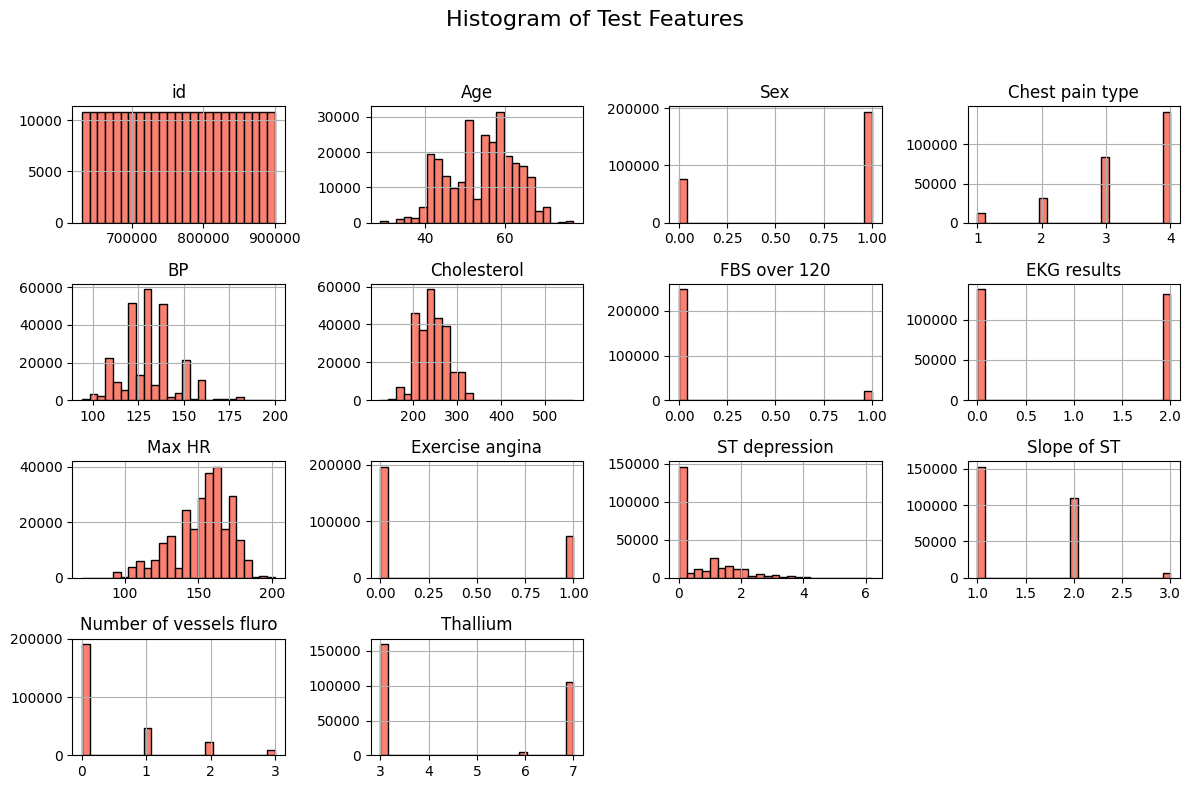

In [13]:
# Histogram for train columns with color
train[train_cols].hist(figsize=(12, 8), bins=25, color='skyblue', edgecolor='black')
plt.suptitle("Histogram of Train Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Histogram for test columns with a different color
test[test_cols].hist(figsize=(12, 8), bins=25, color='salmon', edgecolor='black')
plt.suptitle("Histogram of Test Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

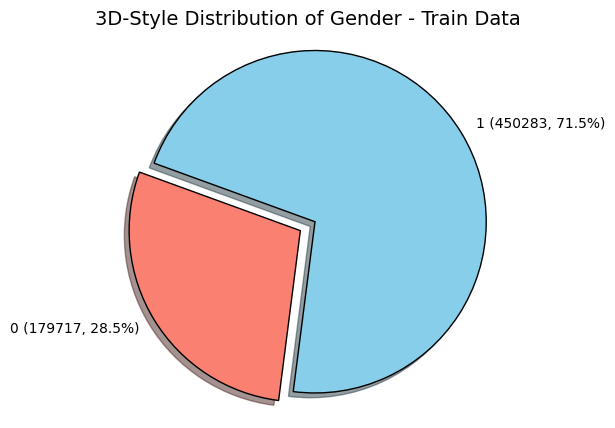

In [14]:
counts = train['Sex'].value_counts()
percentages = (counts / counts.sum()) * 100

# Labels with counts and percentages
labels = [f'{label} ({count}, {perc:.1f}%)' for label, count, perc in zip(counts.index, counts.values, percentages)]

# 3D effect using 'explode' and 'shadow'
explode = [0.05] * len(counts)  # Slightly pull each slice out
colors = ['skyblue', 'salmon']  # Custom colors for slices

plt.figure(figsize=(7, 5))
plt.pie(counts, labels=labels, explode=explode, shadow=True, startangle=160,
        counterclock=False, wedgeprops={'edgecolor': 'black'}, colors=colors)
plt.title('3D-Style Distribution of Gender - Train Data', fontsize=14)
plt.axis('equal')  # Ensures pie is circular
plt.show()

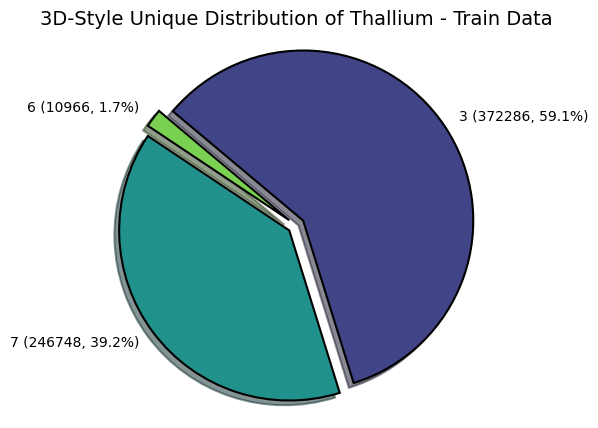

In [15]:
counts = train['Thallium'].value_counts()
percentages = (counts / counts.sum()) * 100
labels = [f'{label} ({count}, {perc:.1f}%)' for label, count, perc in zip(counts.index, counts.values, percentages)]
explode = [0.05] * len(counts)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(counts)))
plt.figure(figsize=(7, 5))
plt.pie(counts, labels=labels, explode=explode, shadow=True, startangle=140,
        counterclock=False, wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}, colors=colors)
plt.title('3D-Style Unique Distribution of Thallium - Train Data', fontsize=14)
plt.axis('equal') 
plt.show()

In [16]:
from sklearn.preprocessing import LabelEncoder

# Encode target column
le = LabelEncoder()
train['Heart Disease'] = le.fit_transform(train['Heart Disease'])

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
id,,,,,,,,,,,,,,
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0


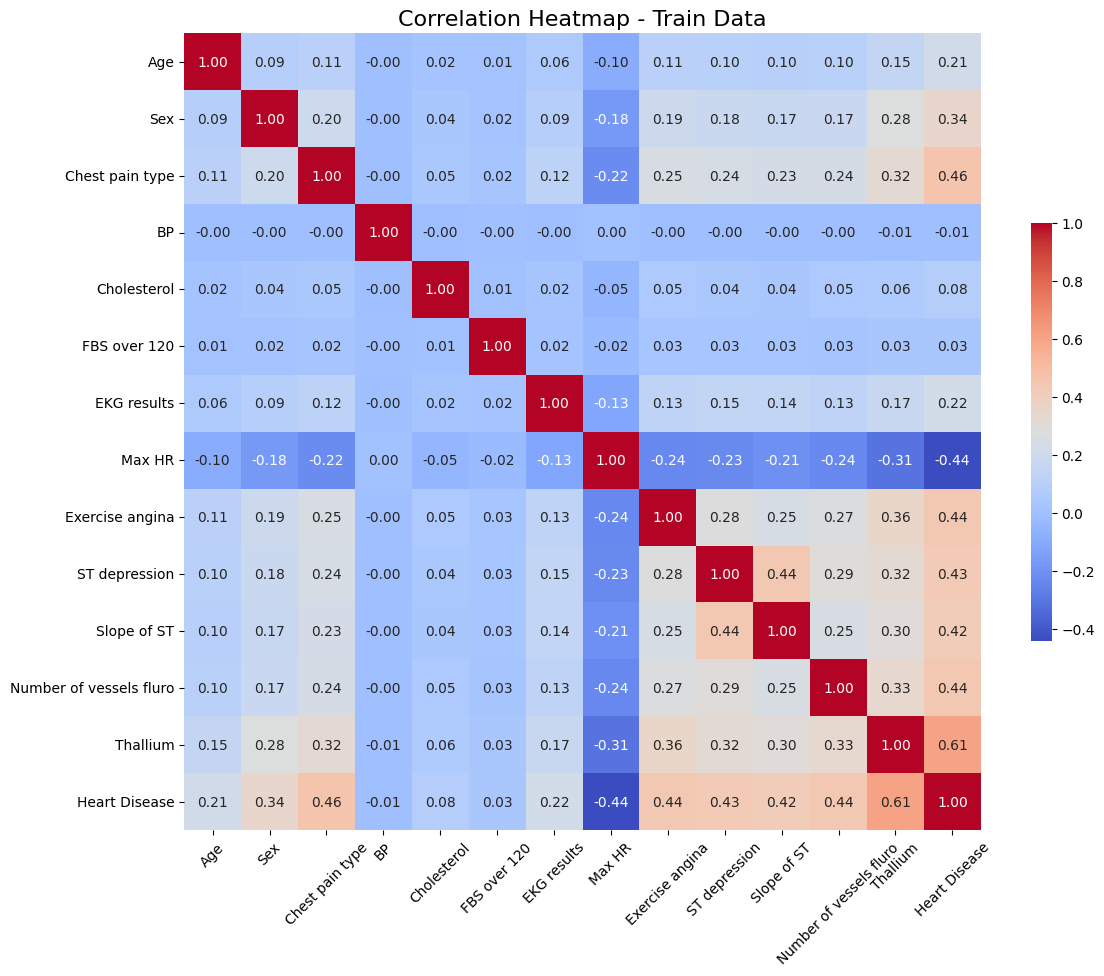

In [17]:
display(train.head(3))

# Compute correlation matrix
corr_train = train.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_train, 
    annot=True,          # Show correlation values
    fmt=".2f",           # Format to 2 decimal places
    cmap='coolwarm',     # Color map
    square=True,         # Square cells
    cbar_kws={"shrink": 0.5}  
)
plt.title("Correlation Heatmap - Train Data", fontsize=16)
plt.xticks(rotation=45)  
plt.yticks(rotation=0)   
plt.tight_layout()
plt.show()

## Feature Engineering

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [19]:
X = train.drop(['Heart Disease'], axis=1)  # Keep all features
y = train['Heart Disease']

In [20]:
le_target = LabelEncoder()
y = le_target.fit_transform(y)

In [21]:
cat_cols = ['Chest pain type', 'EKG results', 'Slope of ST', 'Thallium']
num_cols = [col for col in X.columns if col not in cat_cols]

In [22]:
encoder_transformer = ColumnTransformer(
    transformers=[
        ('target_enc', TargetEncoder(), cat_cols),  # No random_state here
    ],
    remainder='passthrough'  # Leave numerical columns as-is
)

preprocessor = Pipeline([
    ('encoder', encoder_transformer),
    ('scaler', StandardScaler())
])

In [23]:
xgb_params = {
    'n_estimators': 962, 
    'learning_rate': 0.04, 
    'max_depth': 5, 
    'min_child_weight': 5, 
    'subsample': 0.97, 
    'colsample_bytree': 0.516, 
    'gamma': 0.157, 
    'eval_metric': 'logloss',  # Keep eval_metric
    'random_state': 42
}

lgbm_params = {
    'n_estimators': 838, 
    'learning_rate': 0.1, 
    'num_leaves': 151, 
    'max_depth': 3, 
    'min_child_samples': 86, 
    'subsample': 0.93, 
    'colsample_bytree': 0.516, 
    'verbose': -1,
    'random_state': 42
}
estimators = [
    ('xgb', XGBClassifier(**xgb_params)),
    ('lgbm', LGBMClassifier(**lgbm_params))
]

stacking_model = Pipeline([
    ('preprocessor', preprocessor),  # Your TargetEncoder + StandardScaler pipeline
    ('stacking', StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(),
        stack_method='predict_proba',  # Predict probabilities for meta-model
        cv=5,
        n_jobs=-1
    ))
])

In [24]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [25]:
stacking_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('target_enc',
                                                                   TargetEncoder(),
                                                                   ['Chest '
                                                                    'pain type',
                                                                    'EKG '
                                                                    'results',
                                                                    'Slope of '
                                                                    'ST',
                                                                    'Thallium'])])),
                                 ('scaler', StandardScaler())])),
                ('stacking',
                 StackingClassifier(cv=5,
                                    estimators=[('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=No...
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=962,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('lgbm',
                                                 LGBMClassifier(colsample_bytree=0.516,
                                                                max_depth=3,
                                                                min_child_samples=86,
                                                                n_estimators=838,
                                                                num_leaves=151,
                                                                random_state=42,
                                                                subsample=0.93,
                                                                verbose=-1))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1, stack_method='predict_proba'))])

In [26]:
y_pred_proba = stacking_model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)
print(f'Validation ROC-AUC: {auc:.4f}')

Validation ROC-AUC: 0.9563


In [27]:
print("Retraining on complete training data...")
stacking_model.fit(X, y)

Retraining on complete training data...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('target_enc',
                                                                   TargetEncoder(),
                                                                   ['Chest '
                                                                    'pain type',
                                                                    'EKG '
                                                                    'results',
                                                                    'Slope of '
                                                                    'ST',
                                                                    'Thallium'])])),
                                 ('scaler', StandardScaler())])),
                ('stacking',
                 StackingClassifier(cv=5,
                                    estimators=[('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=No...
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=962,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('lgbm',
                                                 LGBMClassifier(colsample_bytree=0.516,
                                                                max_depth=3,
                                                                min_child_samples=86,
                                                                n_estimators=838,
                                                                num_leaves=151,
                                                                random_state=42,
                                                                subsample=0.93,
                                                                verbose=-1))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1, stack_method='predict_proba'))])

In [28]:
submission_csv = pd.DataFrame({
    'id': test.index,
    'Heart Disease': stacking_model.predict_proba(test)[:, 1]
})

submission_csv.to_csv('submission.csv', index=False)
submission_csv.head()

,id,Heart Disease
0,0,0.948262
1,1,0.040428
2,2,0.959157
3,3,0.039339
4,4,0.119121


## Thank you..pls upvote!!!!